In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import AveragePooling1D, Activation, Flatten, Dense
from keras.layers import GlobalMaxPooling1D, Dropout
from keras.layers import GlobalAveragePooling1D, UpSampling1D
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import SGD, Adam, Nadam, Adamax
from keras.layers.normalization import BatchNormalization
import keras.backend as K
from data_in_2s import data_in, normali
from ori_model import ori_model
from keras import metrics
#from tqdm import tqdm
#from sklearn.model_selection import train_test_split

/Users/xufanxiong/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
num_test = 2
X_train, y_train = data_in(num_test)

In [3]:
#Nomalization
#y_train = (y_train-50)/150
X_train = normali(X_train)
print('Shape of X_train is: ' + str(X_train.shape))
print('Shape of y_train is: ' + str(y_train.shape))

Shape of X_train is: (6099, 1000, 5)
Shape of y_train is: (6099, 1)


In [4]:
#Import and Split test data

name_x = 'Training_data/DATA_%.2d_TYPE02.mat'%num_test
in_tem_x = sio.loadmat(name_x)['sig']
in_tem_x = in_tem_x.T

name_y = 'Training_data/DATA_%.2d_TYPE02_BPMtrace.mat'%num_test
in_tem_y = sio.loadmat(name_y)['BPM0']

X_test_tem = np.zeros((in_tem_y.shape[0]*2, 125*8, 5))

k = 0

for j in range(in_tem_y.shape[0]*2-1):
	X_test_tem[j, :, :] =  in_tem_x[k:(k+125*8), 1:]
	k += 125

tem_y = np.zeros((in_tem_y.shape[0]*2, 1))
index = [a*2 for a in range(in_tem_y.shape[0])]
tem_y[index] = in_tem_y

for b in range(tem_y.shape[0]-1):
	if tem_y[b] == 0:
		tem_y[b] = (tem_y[b-1] + tem_y[b+1])/2.

y_test = tem_y[:-1, :]
X_test = X_test_tem[:-1, :, :]

#y_test = (y_test-50)/150
X_test = normali(X_test)

print('The shape of X_test is: ' + str(X_test.shape))
print('The shape of y_test is: ' + str(y_test.shape))

The shape of X_test is: (295, 1000, 5)
The shape of y_test is: (295, 1)


In [5]:
#Convert to spectrum
#68 - 178

spe_len = 110
y_train = np.rint(y_train)
y_test = np.rint(y_test)

y_train_onehot = np.zeros((y_train.shape[0], spe_len))
y_test_onehot = np.zeros((y_test.shape[0], spe_len))

y_train = y_train - 68
y_test = y_test - 68

for i in range(y_train.shape[0]):
    y_train_onehot[i, int(y_train[i][0])] = 1
    
for i in range(y_test.shape[0]):
    y_test_onehot[i, int(y_test[i][0])] = 1
    
print('The shape of y_train_onehot is: ' + str(y_train_onehot.shape))
print('The shape of y_test_onehot is: ' + str(y_test_onehot.shape))


The shape of y_train_onehot is: (6099, 110)
The shape of y_test_onehot is: (295, 110)


In [6]:
model = ori_model((1000, 5), 8, pool_size=4)

/Users/xufanxiong/Desktop/untitled folder 2/ori_model.py:93: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  model = Model(input=inputs, output=output)


In [7]:
optm = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=3*10**(-4))
def top_3_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)
def top_5_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)
model.compile(loss= "categorical_crossentropy", 
              optimizer=optm, 
              metrics=["accuracy", top_5_accuracy])

In [8]:
filepath="weight_spe.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_top_5_accuracy', 
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
callbacks_list = [checkpoint]
history = model.fit(X_train, y_train_onehot, 
                    epochs=50, 
                    batch_size=128, 
                    validation_split=0.3, 
                    callbacks=callbacks_list,
                    shuffle=True,
                    verbose=1)

Train on 4269 samples, validate on 1830 samples
Epoch 1/50
4269/4269 [==============================] - 6s 1ms/step - loss: 4.7243 - acc: 0.0225 - top_5_accuracy: 0.0921 - val_loss: 4.8222 - val_acc: 0.0098 - val_top_5_accuracy: 0.0470

Epoch 00001: val_top_5_accuracy improved from -inf to 0.04699, saving model to weight_spe.hdf5
Epoch 2/50
4269/4269 [==============================] - 5s 1ms/step - loss: 4.4925 - acc: 0.0363 - top_5_accuracy: 0.1438 - val_loss: 4.8865 - val_acc: 0.0077 - val_top_5_accuracy: 0.0393

Epoch 00002: val_top_5_accuracy did not improve from 0.04699
Epoch 3/50
4269/4269 [==============================] - 5s 1ms/step - loss: 4.3531 - acc: 0.0478 - top_5_accuracy: 0.1787 - val_loss: 4.9971 - val_acc: 0.0131 - val_top_5_accuracy: 0.0459

Epoch 00003: val_top_5_accuracy did not improve from 0.04699
Epoch 4/50
4269/4269 [==============================] - 5s 1ms/step - loss: 4.2183 - acc: 0.0506 - top_5_accuracy: 0.2036 - val_loss: 5.3014 - val_acc: 0.0027 - val_top


Epoch 00032: val_top_5_accuracy improved from 0.09891 to 0.10437, saving model to weight_spe.hdf5
Epoch 33/50
4269/4269 [==============================] - 5s 1ms/step - loss: 1.8644 - acc: 0.4106 - top_5_accuracy: 0.8550 - val_loss: 7.5559 - val_acc: 0.0251 - val_top_5_accuracy: 0.1098

Epoch 00033: val_top_5_accuracy improved from 0.10437 to 0.10984, saving model to weight_spe.hdf5
Epoch 34/50
4269/4269 [==============================] - 5s 1ms/step - loss: 1.8455 - acc: 0.4113 - top_5_accuracy: 0.8578 - val_loss: 7.1401 - val_acc: 0.0333 - val_top_5_accuracy: 0.1404

Epoch 00034: val_top_5_accuracy improved from 0.10984 to 0.14044, saving model to weight_spe.hdf5
Epoch 35/50
4269/4269 [==============================] - 5s 1ms/step - loss: 1.8068 - acc: 0.4287 - top_5_accuracy: 0.8613 - val_loss: 8.1183 - val_acc: 0.0251 - val_top_5_accuracy: 0.1109

Epoch 00035: val_top_5_accuracy did not improve from 0.14044
Epoch 36/50
4269/4269 [==============================] - 5s 1ms/step - los

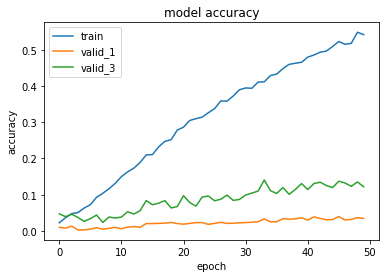

In [9]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['val_top_5_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid_1', 'valid_3'], loc='upper left')
plt.show()

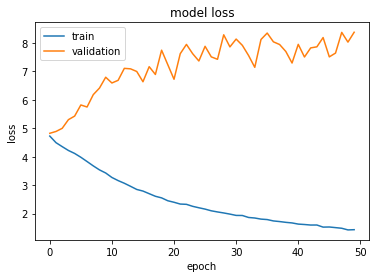

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [11]:
filepath="weight_spe.hdf5"
model.load_weights(filepath)

In [12]:
predict = model.predict(X_test)

In [13]:
predict.shape

(295, 110)

In [14]:
#evaluate
eva = model.evaluate(X_test, y_test_onehot, batch_size=32, verbose=1, sample_weight=None)
print()
print("Loss = " + str(eva[0]))
print("Test Accuracy = " + str(eva[1]))

295/295 [==============================] - 0s 422us/step

Loss = 5.606846806962611
Test Accuracy = 0.033898305236283


In [30]:
#y_pre = np.reshape(np.argmax(predict, axis=1), (predict.shape[0], 1))
#y_pre = y_pre*150 - 50
tem = np.zeros((predict.shape[0], predict.shape[1]))
for i in range(tem.shape[1]):
    tem[:, i] = i
y_pre = np.sum(tem*predict, axis=1, keepdims=True)

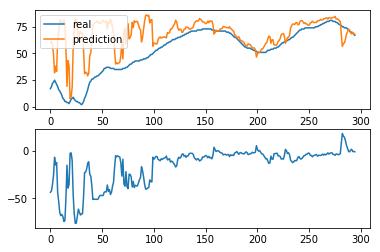

In [31]:
plt.subplot(211)
plt.plot(y_test)
plt.plot(y_pre)
plt.legend(['real', 'prediction'], loc='upper left')
plt.subplot(212)
plt.plot(y_test-y_pre)
plt.show()

In [32]:
Y_error = abs(y_pre - y_test)
print('The avarage predict error: ', np.mean(Y_error))

The avarage predict error:  16.230582650361747
